In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from models import Classifier, BayesClassifier, PGDAttackClassifier, PGDAttackCombined
from eval_utils import BaseDetectorFactory, load_mnist_data
from eval_utils import get_adv_errors, get_nat_accs

from sklearn.metrics import roc_auc_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)

np.random.seed(123)


In [23]:
def load_fashion_mnist():
    dataset = tf.keras.datasets.fashion_mnist

    (x_train, y_train), (x_test, y_test) = dataset.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train = np.reshape(x_train, [x_train.shape[0], -1])
    x_test = np.reshape(x_test, [x_test.shape[0], -1])
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist_data()
(x_train_fmnist, y_train_fmnist), (x_test_fmnist, y_test_fmnist) = load_fashion_mnist()

In [24]:
classifier = Classifier(var_scope='classifier', dataset='MNIST')
classifier_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                    scope='classifier')
classifier_saver = tf.train.Saver(var_list=classifier_vars, max_to_keep=1)
factory = BaseDetectorFactory(eps=0.3)

In [25]:
sess = tf.Session()

In [26]:
classifier_saver.restore(sess, 'checkpoints/mnist/classifier')
factory.restore_base_detectors(sess)
base_detectors = factory.get_base_detectors()

bayes_classifier = BayesClassifier(base_detectors)

In [47]:
target_class = 9
detector = base_detectors[target_class]
in_class_logit_out = sess.run(detector.logits, feed_dict={detector.x_input:x_test[y_test==target_class]})
out_class_logit_out = sess.run(detector.logits, feed_dict={detector.x_input:x_test_fmnist})

(1009,) (10000,)
auc score: 1.0


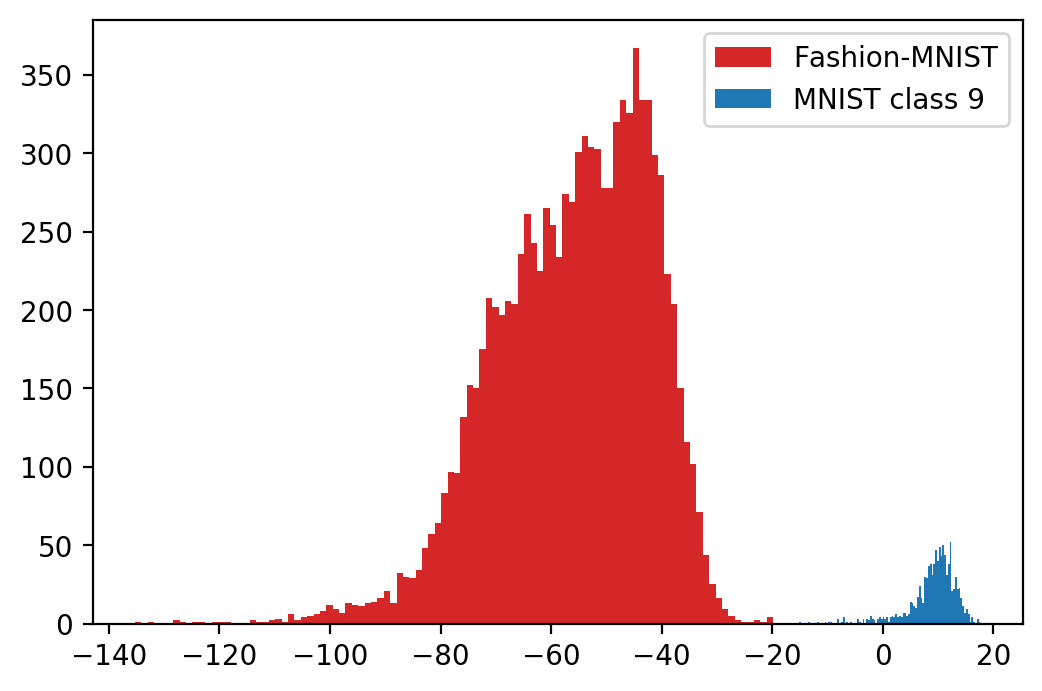

In [49]:
print(in_class_logit_out.shape, out_class_logit_out.shape)
y_true = np.concatenate([np.ones(in_class_logit_out.shape[0]), np.zeros(out_class_logit_out.shape[0])])
y_scores = np.concatenate([in_class_logit_out, out_class_logit_out])
print('auc score: {}'.format(roc_auc_score(y_true, y_scores)))

bins = 100
plt.figure(dpi=200)
plt.hist(out_class_logit_out, color='tab:red', bins=bins, label='Fashion-MNIST')
plt.hist(in_class_logit_out, color='tab:blue', bins=bins, label='MNIST class {}'.format(target_class))
plt.legend();

(60000, 28, 28)